In [33]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [34]:
df = pd.read_json("temperature-sweep.jsonl", lines=True)
print(len(df))
df.head()

381


,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal,cq,empty.json,1,0.000000,0.000241,0.000000,0.000465,0.000000,0.000000,0.000000,0.000000,Standard,0
1,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format,cq,empty.json,1,0.247000,0.349548,0.287540,0.400635,0.225000,0.332254,0.162963,0.224074,Standard,0
2,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format-few,cq,empty.json,1,0.254861,0.367591,0.305112,0.417707,0.228947,0.355259,0.148148,0.235804,Standard,0
3,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/helpful-output-format-few,cq,empty.json,1,0.261067,0.367635,0.293131,0.406256,0.247368,0.357748,0.187654,0.266800,Standard,0
4,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format-few-no-prio,cq,empty.json,1,0.256930,0.361924,0.285942,0.394483,0.248684,0.365605,0.182716,0.254365,Standard,0


In [35]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [36]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,0.0,cot/excellent-format-reasoning,cq,empty.json,1,0.407944,0.489914,0.533546,0.625827,0.311842,0.377059,0.200000,0.281535,COT,0
1,0.0,cot/excellent-format-reasoning,cq,empty.json,2,0.407116,0.492792,0.527955,0.625286,0.310526,0.382631,0.214815,0.289931,COT,0
2,0.0,cot/excellent-format-reasoning,cq,empty.json,3,0.401738,0.489893,0.530351,0.627570,0.301316,0.377814,0.192593,0.274604,COT,0
3,0.1,cot/excellent-format-reasoning,cq,empty.json,1,0.409599,0.493538,0.535144,0.630265,0.306579,0.378292,0.214815,0.287126,COT,0
4,0.1,cot/excellent-format-reasoning,cq,empty.json,2,0.405048,0.490532,0.531949,0.629372,0.307895,0.374431,0.195062,0.279196,COT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,1.5,standard/minimal-output-format-fewest,cq,empty.json,2,0.527513,0.659429,0.585463,0.709983,0.517105,0.666309,0.367901,0.490239,Standard,0
377,1.5,standard/minimal-output-format-fewest,cq,empty.json,3,0.537029,0.661377,0.575080,0.701884,0.548684,0.677860,0.397531,0.505225,Standard,0
378,2.0,standard/minimal-output-format-fewest,cq,empty.json,1,0.271825,0.382596,0.313099,0.421900,0.260526,0.371239,0.165432,0.282405,Standard,0
379,2.0,standard/minimal-output-format-fewest,cq,empty.json,2,0.280099,0.371865,0.321885,0.418983,0.277632,0.375419,0.155556,0.219537,Standard,0


In [37]:
df['params.qa.system_prompt'].unique().tolist()

['cot/excellent-format-reasoning',
 'cot/format-minimal',
 'cot/format-reasoning',
 'cot/format-think',
 'cte/excellent-format-few',
 'cte/excellent-format-fewest',
 'cte/format-few',
 'cte/format-relevant-few',
 'standard/excellent-few',
 'standard/excellent-fewest',
 'standard/helpful-output-format-few',
 'standard/minimal',
 'standard/minimal-output-format',
 'standard/minimal-output-format-few',
 'standard/minimal-output-format-few-no-prio',
 'standard/minimal-output-format-fewest']

In [38]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples", "params.qa.temperature"])[
        "params.run"
    ]
    .aggregate(tuple)
    .reset_index()
)
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run
37,cte/excellent-format-few,cq,empty.json,1.0,"(2, 3)"
39,cte/excellent-format-few,cq,empty.json,2.0,"(1, 2)"
53,cte/format-few,cq,empty.json,1.0,"(1, 3)"


In [39]:
df.columns.to_list()

['params.qa.temperature',
 'params.qa.system_prompt',
 'params.qa.user_prompt_template',
 'params.qa.few_shot_examples',
 'params.run',
 'metrics.exact_match',
 'metrics.f1',
 'metrics.2hops.exact_match',
 'metrics.2hops.f1',
 'metrics.3hops.exact_match',
 'metrics.3hops.f1',
 'metrics.4hops.exact_match',
 'metrics.4hops.f1',
 'params.qa.technique',
 'params.qa.n_shot']

In [40]:
# Average metrics over repeated runs (params.run)
_df = (
    df.groupby(target_param_cols)[metric_cols]
    .agg(["mean", "min", "max", "std"])
    .reset_index()
)
_df.columns = [".".join(col).strip().strip(".") for col in _df.columns.values]
_df.sort_values("metrics.f1.mean", ascending=False, inplace=True)
_df[
    target_param_cols
    + ["metrics.f1.min", "metrics.f1.mean", "metrics.f1.max", "metrics.f1.std"]
]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.f1.min,metrics.f1.mean,metrics.f1.max,metrics.f1.std
52,CTE,cte/format-few,cq,0,0.7,0.704289,0.706863,0.709494,0.002603
50,CTE,cte/format-few,cq,0,0.3,0.704566,0.706332,0.709708,0.002924
51,CTE,cte/format-few,cq,0,0.5,0.705402,0.705885,0.706472,0.000542
53,CTE,cte/format-few,cq,0,1.0,0.696796,0.703466,0.710135,0.009432
49,CTE,cte/format-few,cq,0,0.1,0.700442,0.702069,0.703178,0.001440
...,...,...,...,...,...,...,...,...,...
88,Standard,standard/minimal,cq,0,0.0,0.000000,0.000000,0.000000,0.000000
89,Standard,standard/minimal,cq,0,0.1,0.000000,0.000000,0.000000,0.000000
90,Standard,standard/minimal,cq,0,0.3,0.000000,0.000000,0.000000,0.000000
91,Standard,standard/minimal,cq,0,0.5,0.000000,0.000000,0.000000,0.000000


In [41]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(target_param_cols)[metric_cols]
    .mean()
    .reset_index()
)
df_avg[[*target_param_cols, *metric_cols]].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
52,CTE,cte/format-few,cq,0,0.7,0.583230,0.706863,0.618211,0.742222,0.589035,0.724248,0.464198,0.564931
50,CTE,cte/format-few,cq,0,0.3,0.587643,0.706332,0.623536,0.743323,0.597807,0.723693,0.457613,0.559403
51,CTE,cte/format-few,cq,0,0.5,0.588057,0.705885,0.619276,0.738177,0.605263,0.731468,0.459259,0.558050
53,CTE,cte/format-few,cq,0,1.0,0.582127,0.703466,0.620607,0.740825,0.575000,0.715947,0.476543,0.564551
49,CTE,cte/format-few,cq,0,0.1,0.582127,0.702069,0.618743,0.738315,0.588158,0.718584,0.457613,0.559031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Standard,standard/minimal,cq,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
89,Standard,standard/minimal,cq,0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90,Standard,standard/minimal,cq,0,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
91,Standard,standard/minimal,cq,0,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
def plot_variance(dataf, metric_column):
    # Calculate variance of the specified metric for each experiment group
    grouped_dataf = dataf.groupby([
        'params.qa.temperature',
        'params.qa.technique',
        'params.qa.system_prompt',
        'params.qa.user_prompt_template',
        'params.qa.n_shot'
    ])[metric_column].std().reset_index()
    grouped_dataf.rename(columns={metric_column: f'{metric_column}_std'}, inplace=True)

    # Creating a unique label for each experiment configuration
    grouped_dataf['experiment_label'] = grouped_dataf[
        ['params.qa.temperature', 'params.qa.technique', 'params.qa.system_prompt', 'params.qa.user_prompt_template', 'params.qa.n_shot']
    ].apply(lambda x: ' | '.join(map(str, x)), axis=1)

    # Sort by variance for better visual clarity
    grouped_dataf.sort_values(f'{metric_column}_std', inplace=True)

    # Plot
    metric_name = metric_column.split(".")[-1].upper()
    plt.figure(figsize=(16, int(len(grouped_dataf)*0.3)))
    plt.barh(grouped_dataf['experiment_label'], grouped_dataf[f'{metric_column}_std'], alpha=0.7)
    plt.xlabel(f'Standard Deviation of {metric_column}')
    plt.ylabel('Experiment Configuration')
    plt.title(f'Variance of {metric_name} Score Across Different Experiment Runs')
    plt.tight_layout()
    plt.show()

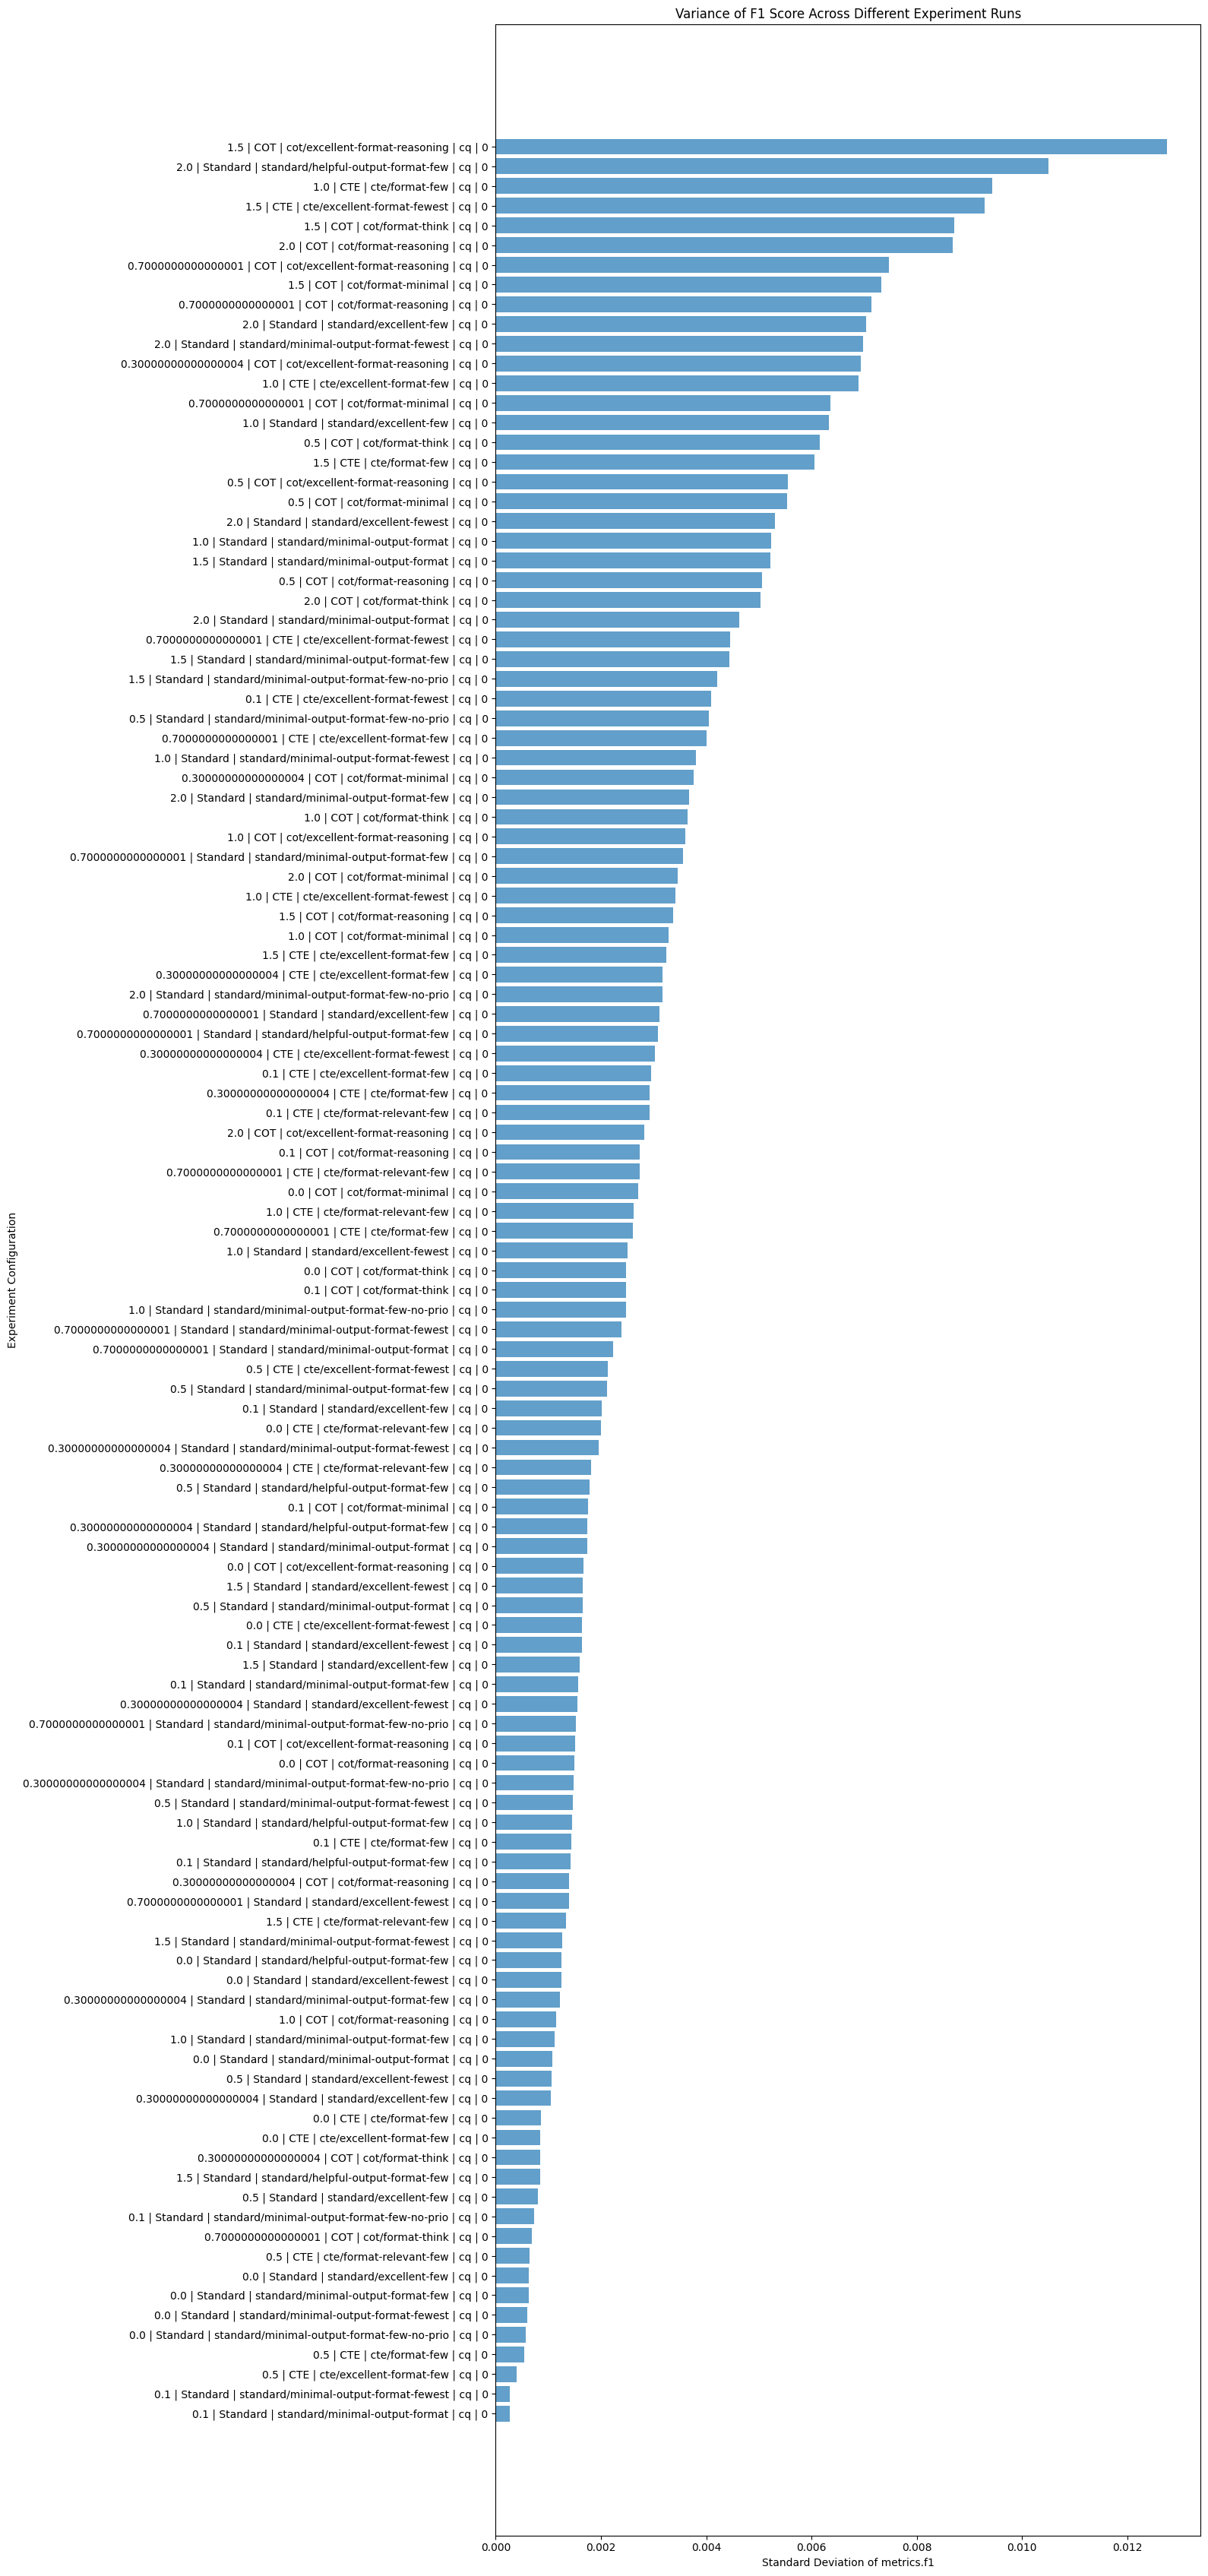

In [43]:
# Filter out experiments with F1 score < 0.1
_df = df[df['metrics.f1'] >= 0.1]
plot_variance(_df, 'metrics.f1')

In [44]:
df_target = df_avg.copy()
df_target.sort_values('metrics.f1', inplace=True, ascending=False)
df_target

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
52,CTE,cte/format-few,cq,0,0.7,0.583230,0.706863,0.618211,0.742222,0.589035,0.724248,0.464198,0.564931
50,CTE,cte/format-few,cq,0,0.3,0.587643,0.706332,0.623536,0.743323,0.597807,0.723693,0.457613,0.559403
51,CTE,cte/format-few,cq,0,0.5,0.588057,0.705885,0.619276,0.738177,0.605263,0.731468,0.459259,0.558050
53,CTE,cte/format-few,cq,0,1.0,0.582127,0.703466,0.620607,0.740825,0.575000,0.715947,0.476543,0.564551
49,CTE,cte/format-few,cq,0,0.1,0.582127,0.702069,0.618743,0.738315,0.588158,0.718584,0.457613,0.559031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Standard,standard/minimal,cq,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
89,Standard,standard/minimal,cq,0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90,Standard,standard/minimal,cq,0,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
91,Standard,standard/minimal,cq,0,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
def plot_metric(dataf, metric, *, ax, title, bar_width, ylabel=None):
    prompts = [
        f"{method}/{sp}/{up}/{fs}"
        for method, sp, up, fs in zip(
            dataf["params.qa.technique"].values,
            dataf["params.qa.system_prompt"].values,
            dataf["params.qa.user_prompt_template"].values,
            dataf["params.qa.n_shot"].values,
        )
    ]
    x = np.arange(len(prompts))
    metrics = {
        "2hops": dataf[f"metrics.2hops.{metric}"].values,
        "3hops": dataf[f"metrics.3hops.{metric}"].values,
        "4hops": dataf[f"metrics.4hops.{metric}"].values,
        "all": dataf[f"metrics.{metric}"].values,
    }
    bars_2hops = ax.bar(x - bar_width, metrics["2hops"], bar_width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], bar_width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + bar_width, metrics["4hops"], bar_width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=90)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)

def plot_dataframe(dataf, bar_width=0.3):
    # Creating subplots for Exact Match and F1, separating them for clarity
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18), sharey=True)

    dataf = dataf.sort_values("metrics.f1")

    # Plotting Exact Match
    plot_metric(dataf, 'exact_match', ax=ax1, title="EM", bar_width=bar_width, ylabel="Score")

    # Plotting F1
    plot_metric(dataf, 'f1', ax=ax2, title="F1", bar_width=bar_width, ylabel="Score")

    # Creating a shared legend outside the plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
    plt.tight_layout()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1
52,CTE,cte/format-few,cq,0,0.7,0.583230,0.706863,0.618211,0.742222
50,CTE,cte/format-few,cq,0,0.3,0.587643,0.706332,0.623536,0.743323
51,CTE,cte/format-few,cq,0,0.5,0.588057,0.705885,0.619276,0.738177
53,CTE,cte/format-few,cq,0,1.0,0.582127,0.703466,0.620607,0.740825
49,CTE,cte/format-few,cq,0,0.1,0.582127,0.702069,0.618743,0.738315
48,CTE,cte/format-few,cq,0,0.0,0.585161,0.701464,0.621140,0.737310
57,CTE,cte/format-relevant-few,cq,0,0.1,0.588608,0.701280,0.621938,0.730238
56,CTE,cte/format-relevant-few,cq,0,0.0,0.585988,0.699753,0.623003,0.731507
104,Standard,standard/minimal-output-format-few,cq,0,0.0,0.574266,0.699507,0.620075,0.736807
83,Standard,standard/helpful-output-format-few,cq,0,0.5,0.575231,0.699279,0.623536,0.741159


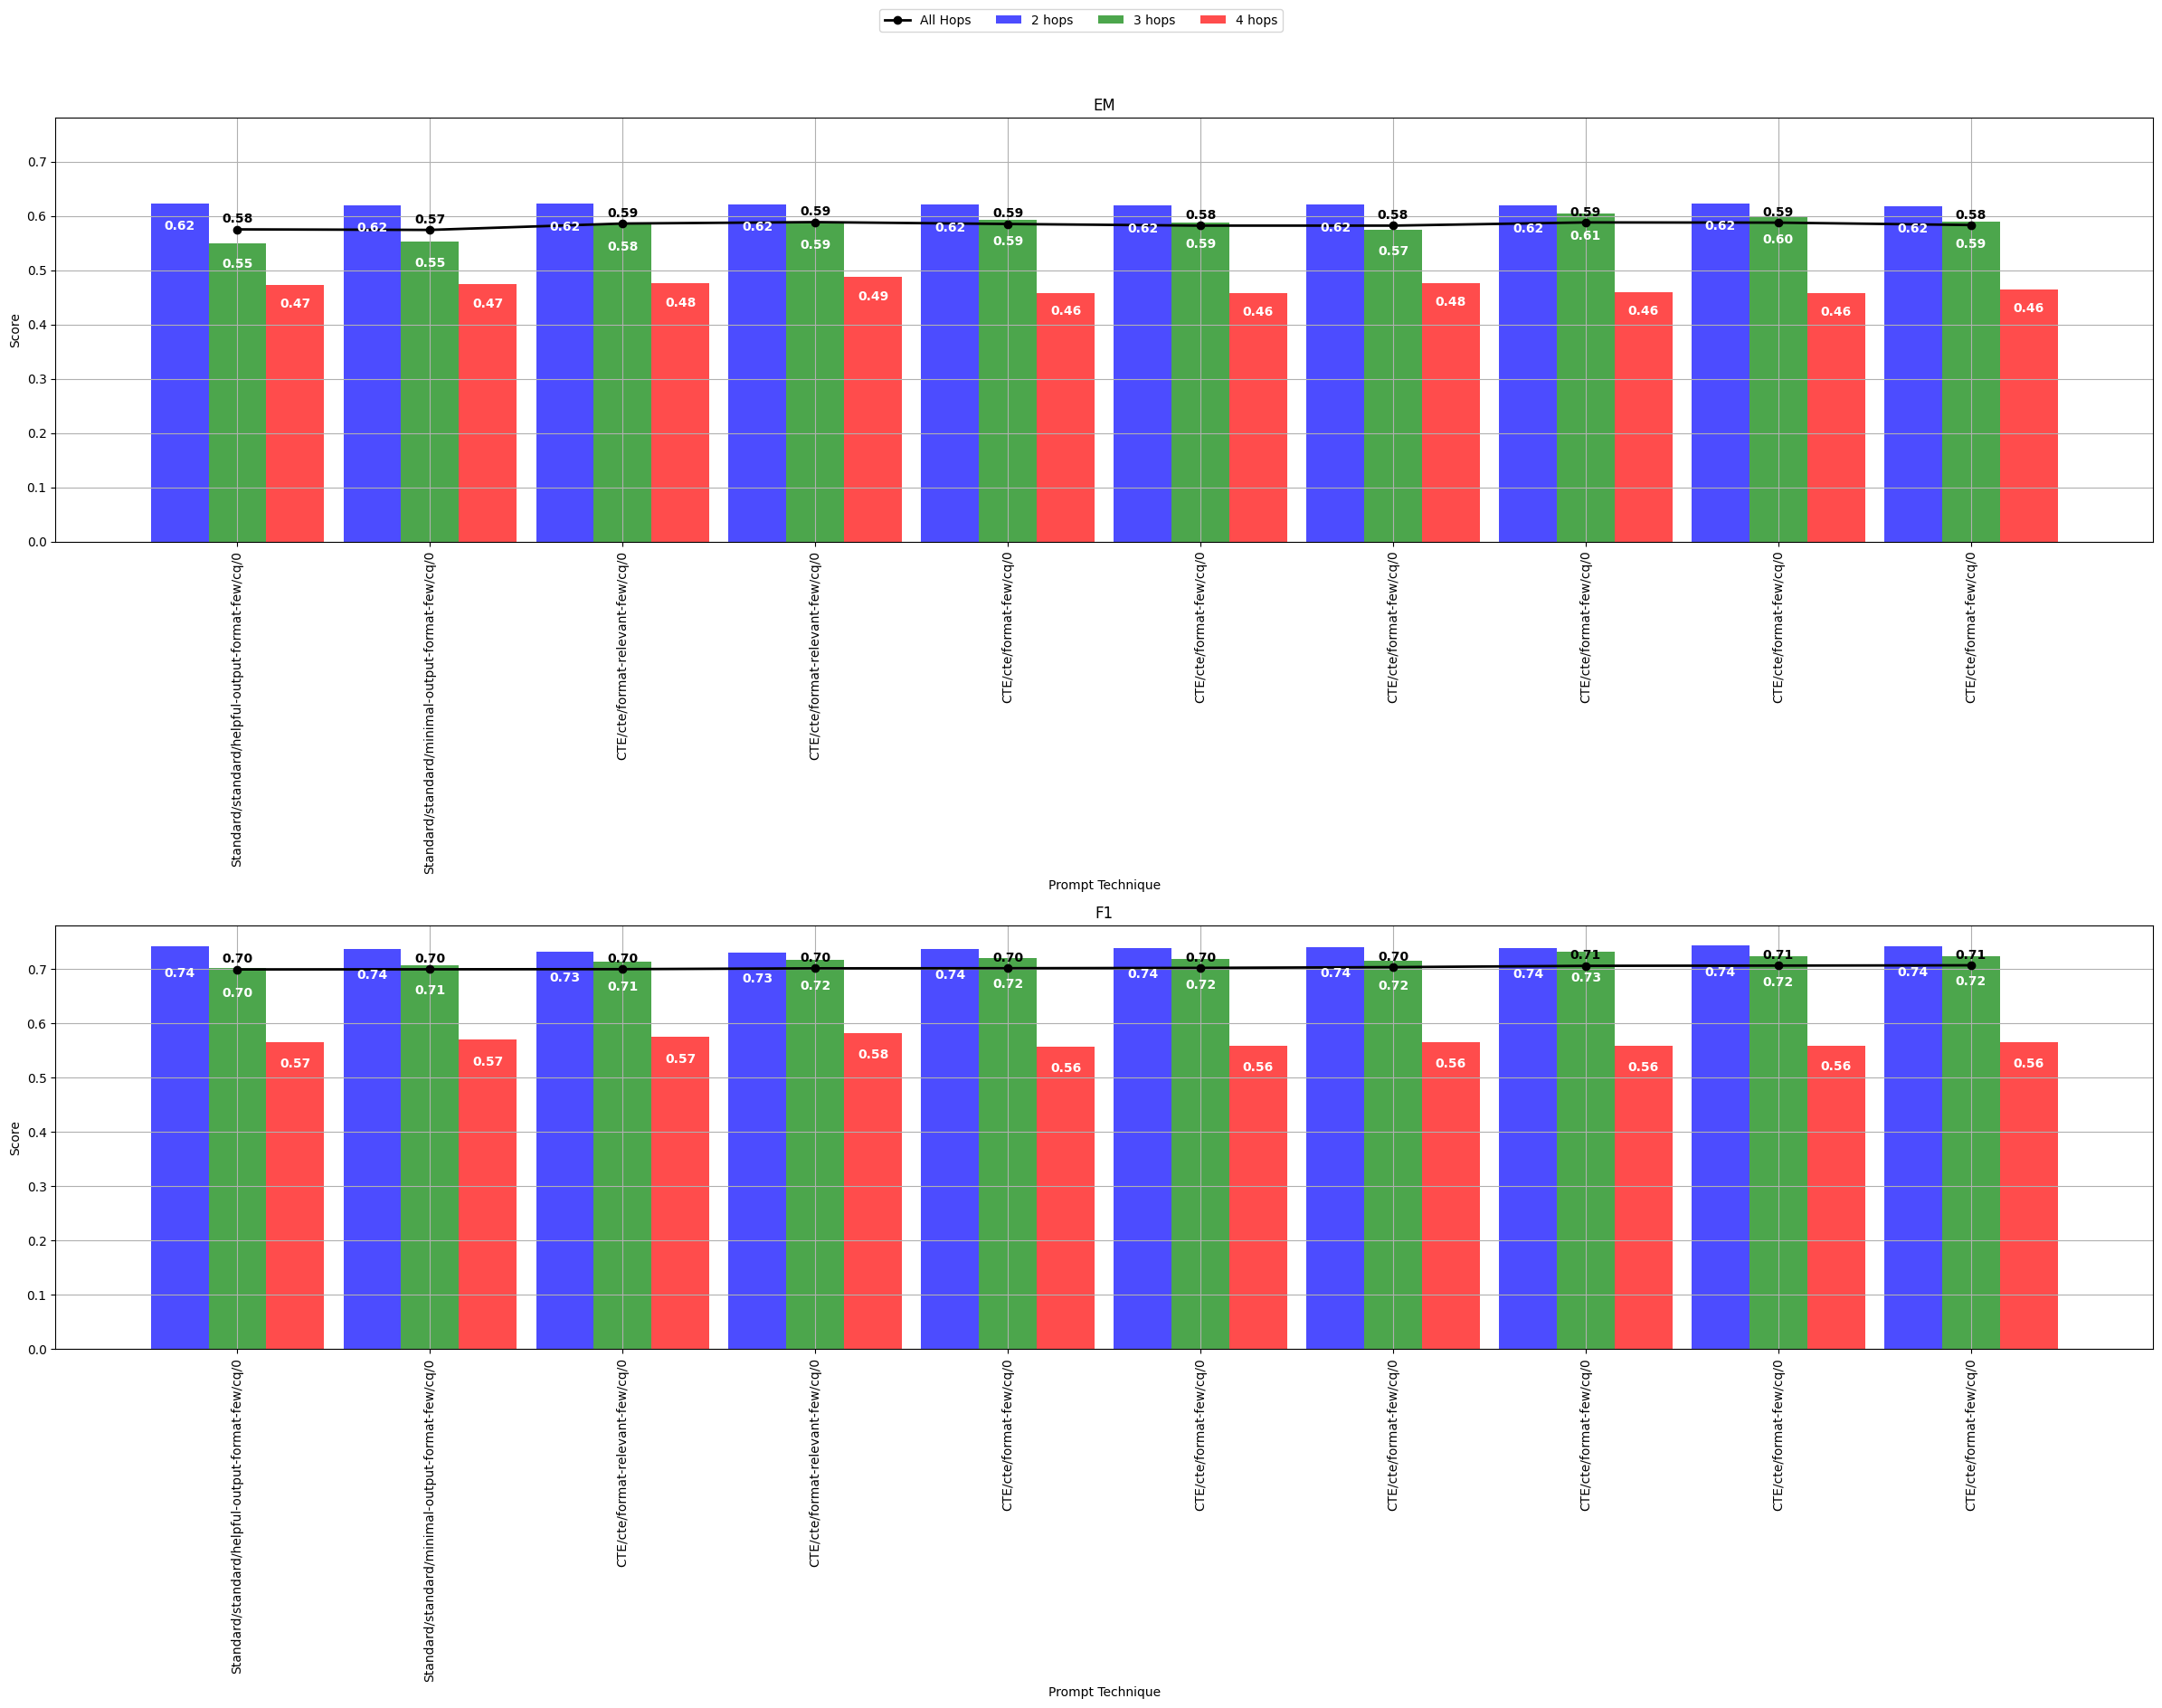

In [46]:
_df = df_target.sort_values('metrics.f1').iloc[-10:]
plot_dataframe(_df)
_df.loc[::-1, target_param_cols + metric_cols[:4]]

In [47]:
mask = df_target.groupby("params.qa.technique")["metrics.f1"].idxmax()
df_target.loc[mask].sort_values("metrics.f1", ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
52,CTE,cte/format-few,cq,0,0.7,0.583230,0.706863,0.618211,0.742222,0.589035,0.724248,0.464198,0.564931
104,Standard,standard/minimal-output-format-few,cq,0,0.0,0.574266,0.699507,0.620075,0.736807,0.552193,0.707299,0.474074,0.569578
8,COT,cot/format-minimal,cq,0,0.0,0.553855,0.667542,0.604899,0.719454,0.527632,0.652391,0.445267,0.535496


,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
52,CTE,cte/format-few,cq,0.7,0.583230,0.706863,0.618211,0.742222,0.589035,0.724248,0.464198,0.564931
50,CTE,cte/format-few,cq,0.3,0.587643,0.706332,0.623536,0.743323,0.597807,0.723693,0.457613,0.559403
51,CTE,cte/format-few,cq,0.5,0.588057,0.705885,0.619276,0.738177,0.605263,0.731468,0.459259,0.558050
53,CTE,cte/format-few,cq,1.0,0.582127,0.703466,0.620607,0.740825,0.575000,0.715947,0.476543,0.564551
49,CTE,cte/format-few,cq,0.1,0.582127,0.702069,0.618743,0.738315,0.588158,0.718584,0.457613,0.559031
...,...,...,...,...,...,...,...,...,...,...,...,...
88,Standard,standard/minimal,cq,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
89,Standard,standard/minimal,cq,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90,Standard,standard/minimal,cq,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
91,Standard,standard/minimal,cq,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


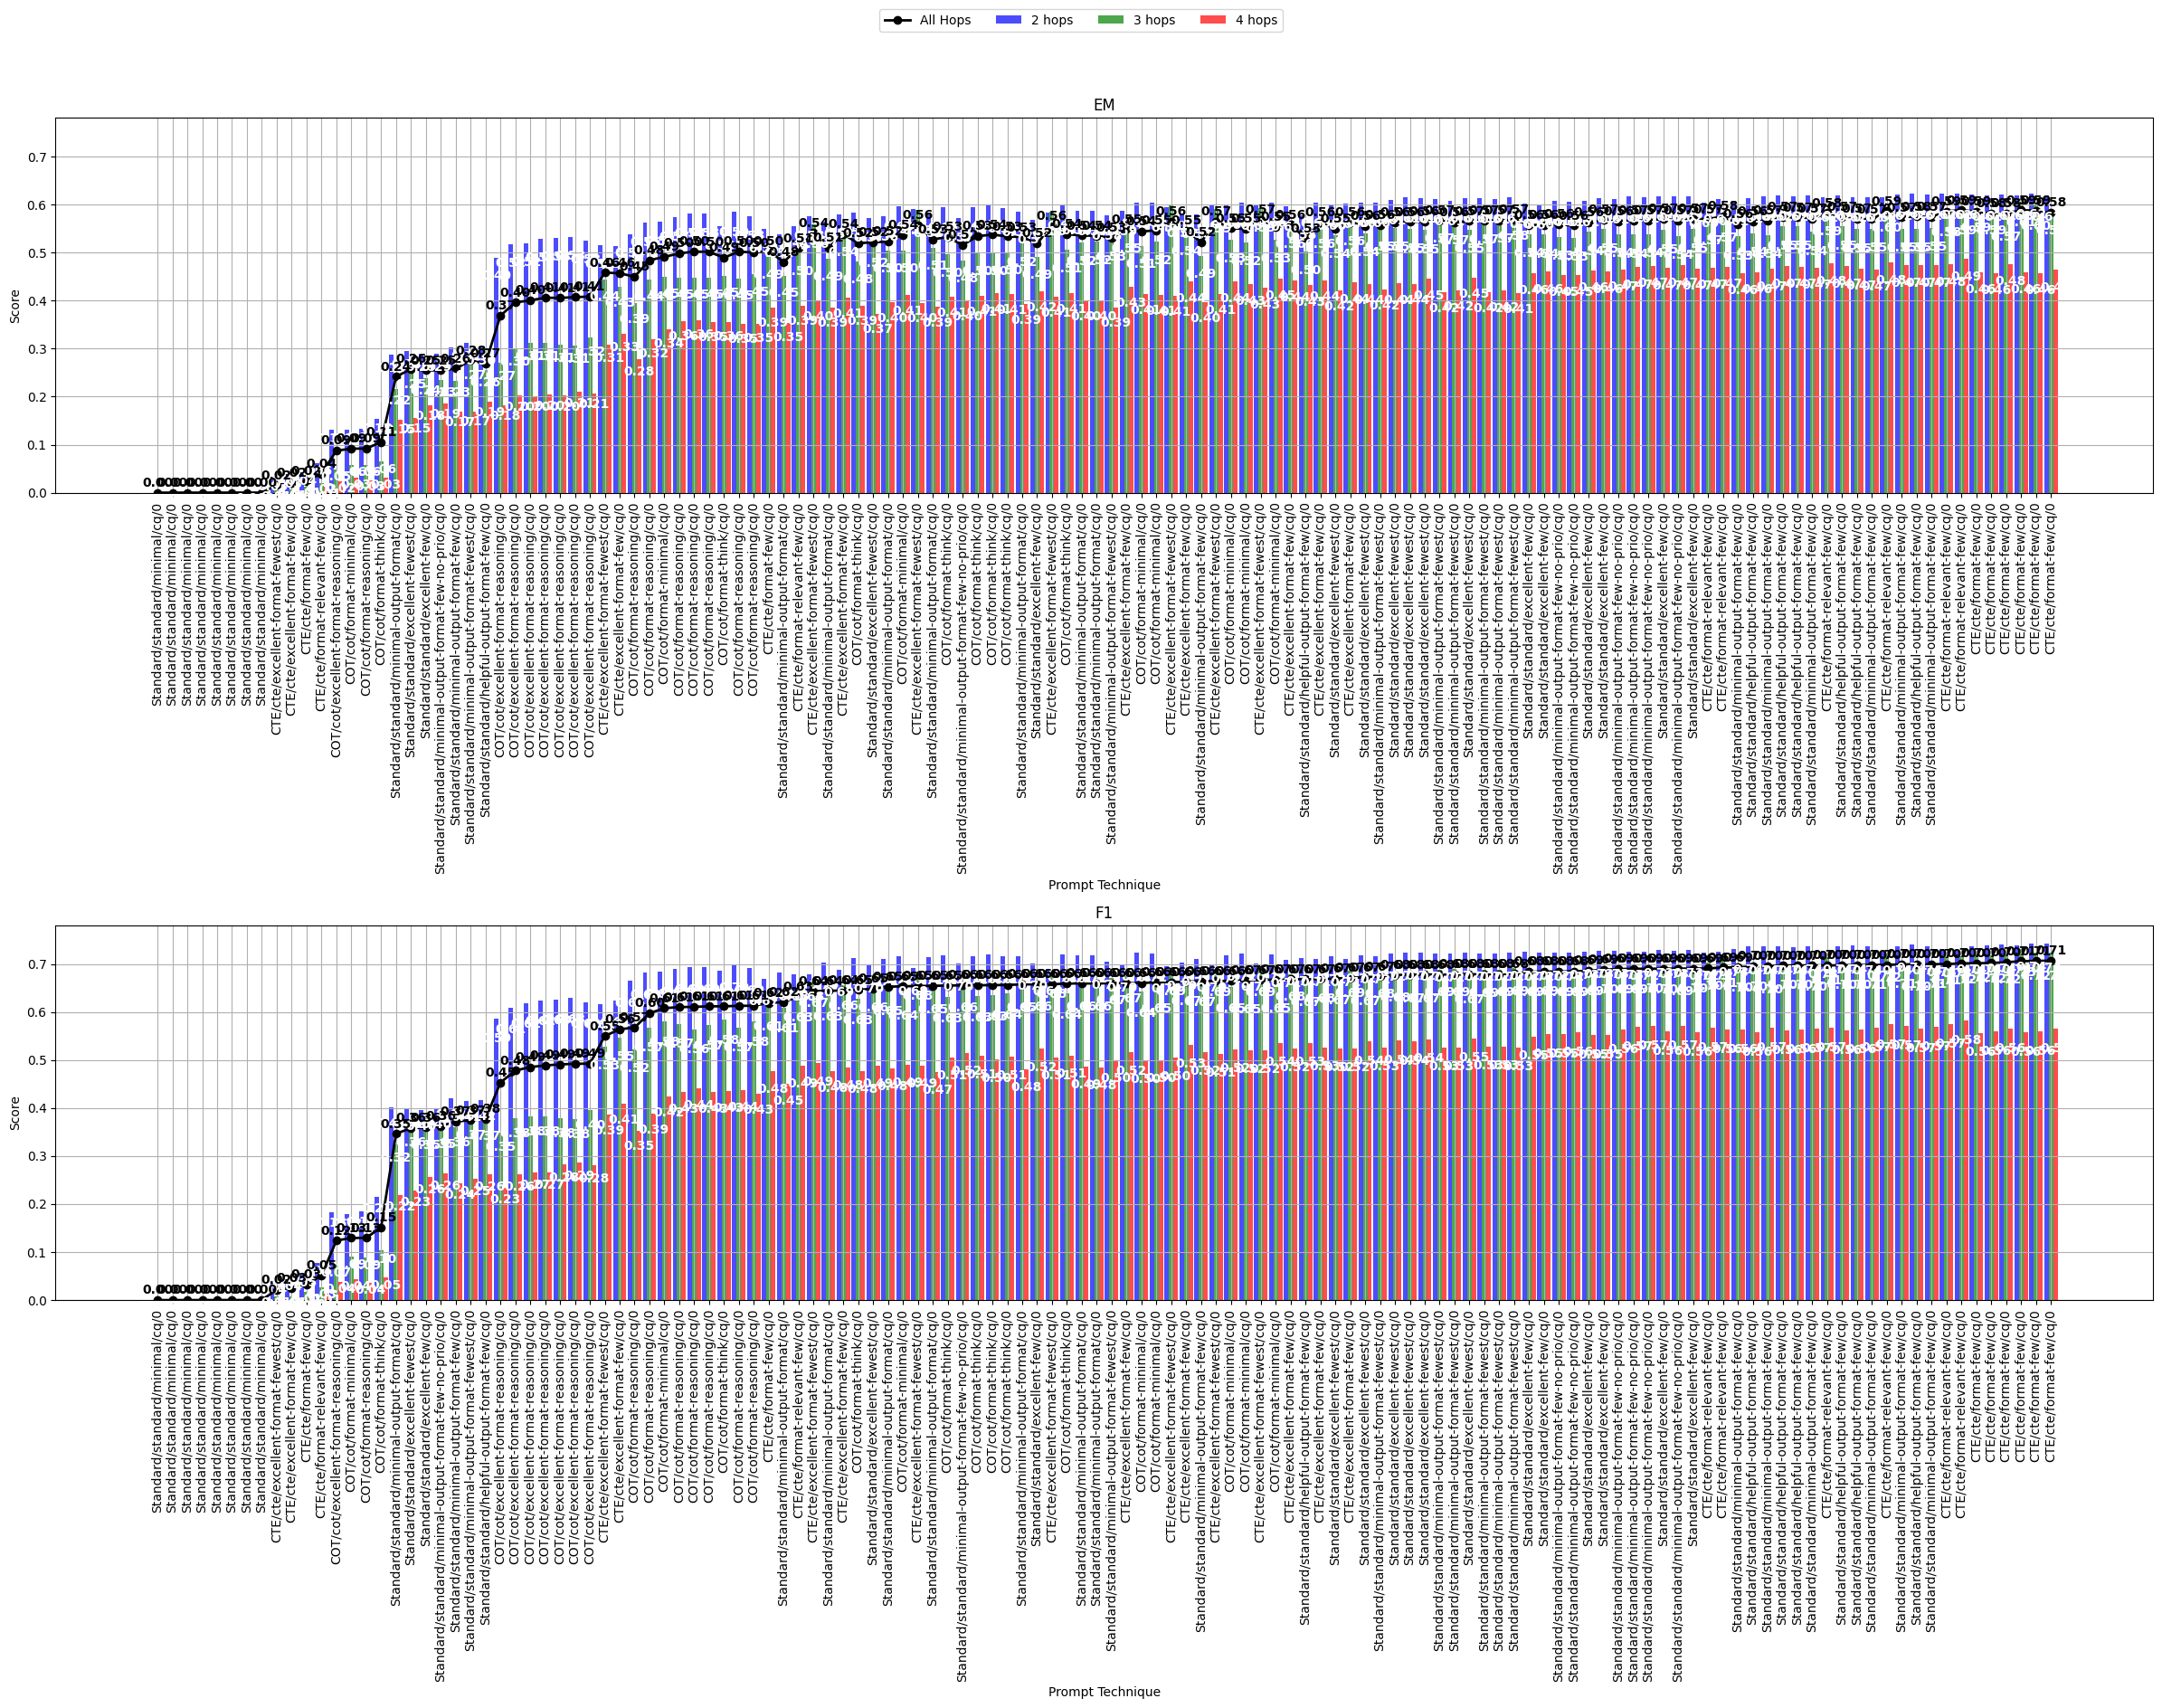

In [48]:
mask = df_target['params.qa.n_shot'] == 0
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False).drop(columns=['params.qa.n_shot'])

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
104,Standard,standard/minimal-output-format-few,cq,0,0.0,0.574266,0.699507,0.620075,0.736807,0.552193,0.707299,0.474074,0.569578
83,Standard,standard/helpful-output-format-few,cq,0,0.5,0.575231,0.699279,0.623536,0.741159,0.550000,0.701286,0.473251,0.566047
105,Standard,standard/minimal-output-format-few,cq,0,0.1,0.573438,0.699174,0.620075,0.736587,0.550000,0.705866,0.473251,0.570958
107,Standard,standard/minimal-output-format-few,cq,0,0.5,0.569577,0.698019,0.615282,0.736090,0.550000,0.705085,0.465021,0.567069
84,Standard,standard/helpful-output-format-few,cq,0,0.7,0.569852,0.697783,0.615815,0.737830,0.549123,0.703599,0.466667,0.563067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Standard,standard/minimal,cq,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
89,Standard,standard/minimal,cq,0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90,Standard,standard/minimal,cq,0,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
91,Standard,standard/minimal,cq,0,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


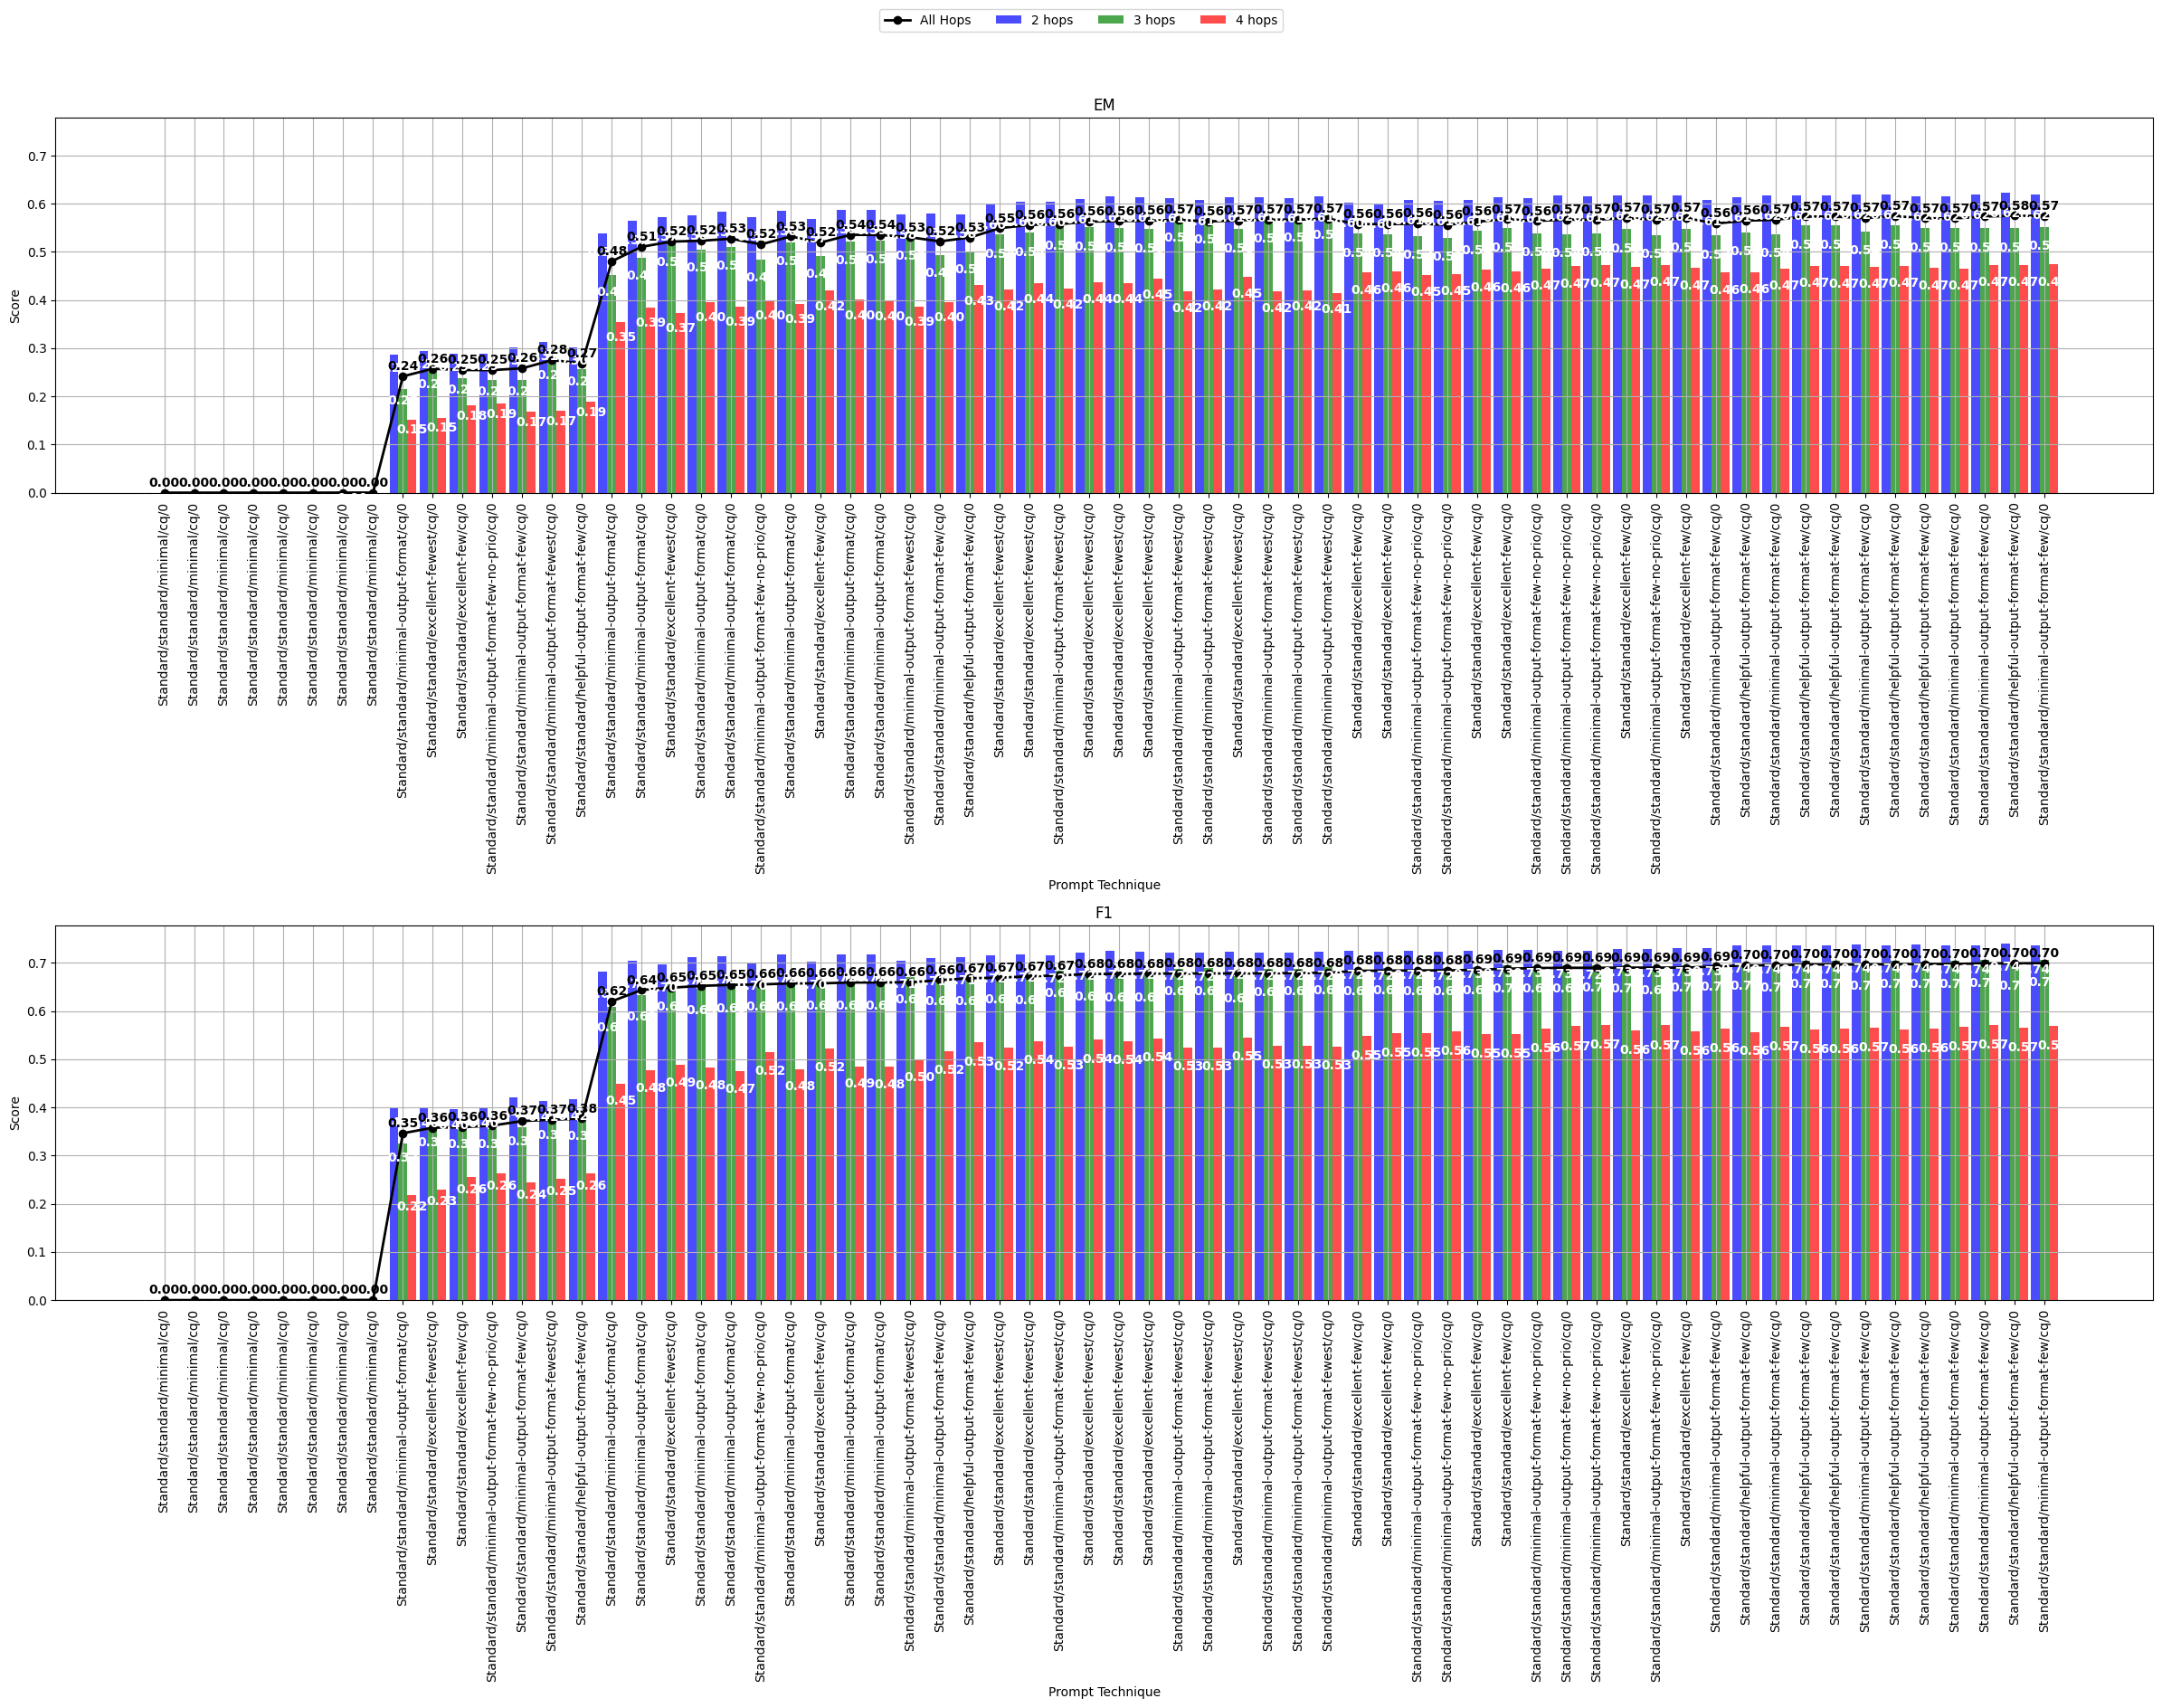

In [49]:
mask = df_target['params.qa.technique'] == 'Standard'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
52,CTE,cte/format-few,cq,0,0.7,0.583230,0.706863,0.618211,0.742222,0.589035,0.724248,0.464198,0.564931
50,CTE,cte/format-few,cq,0,0.3,0.587643,0.706332,0.623536,0.743323,0.597807,0.723693,0.457613,0.559403
51,CTE,cte/format-few,cq,0,0.5,0.588057,0.705885,0.619276,0.738177,0.605263,0.731468,0.459259,0.558050
53,CTE,cte/format-few,cq,0,1.0,0.582127,0.703466,0.620607,0.740825,0.575000,0.715947,0.476543,0.564551
49,CTE,cte/format-few,cq,0,0.1,0.582127,0.702069,0.618743,0.738315,0.588158,0.718584,0.457613,0.559031
48,CTE,cte/format-few,cq,0,0.0,0.585161,0.701464,0.621140,0.737310,0.593421,0.719570,0.458436,0.556677
57,CTE,cte/format-relevant-few,cq,0,0.1,0.588608,0.701280,0.621938,0.730238,0.587719,0.716732,0.487243,0.582763
56,CTE,cte/format-relevant-few,cq,0,0.0,0.585988,0.699753,0.623003,0.731507,0.583772,0.714020,0.475720,0.574820
58,CTE,cte/format-relevant-few,cq,0,0.3,0.586264,0.698213,0.615282,0.724996,0.595175,0.720057,0.479835,0.574425
59,CTE,cte/format-relevant-few,cq,0,0.5,0.582954,0.697000,0.615282,0.728127,0.585965,0.714620,0.477366,0.567712


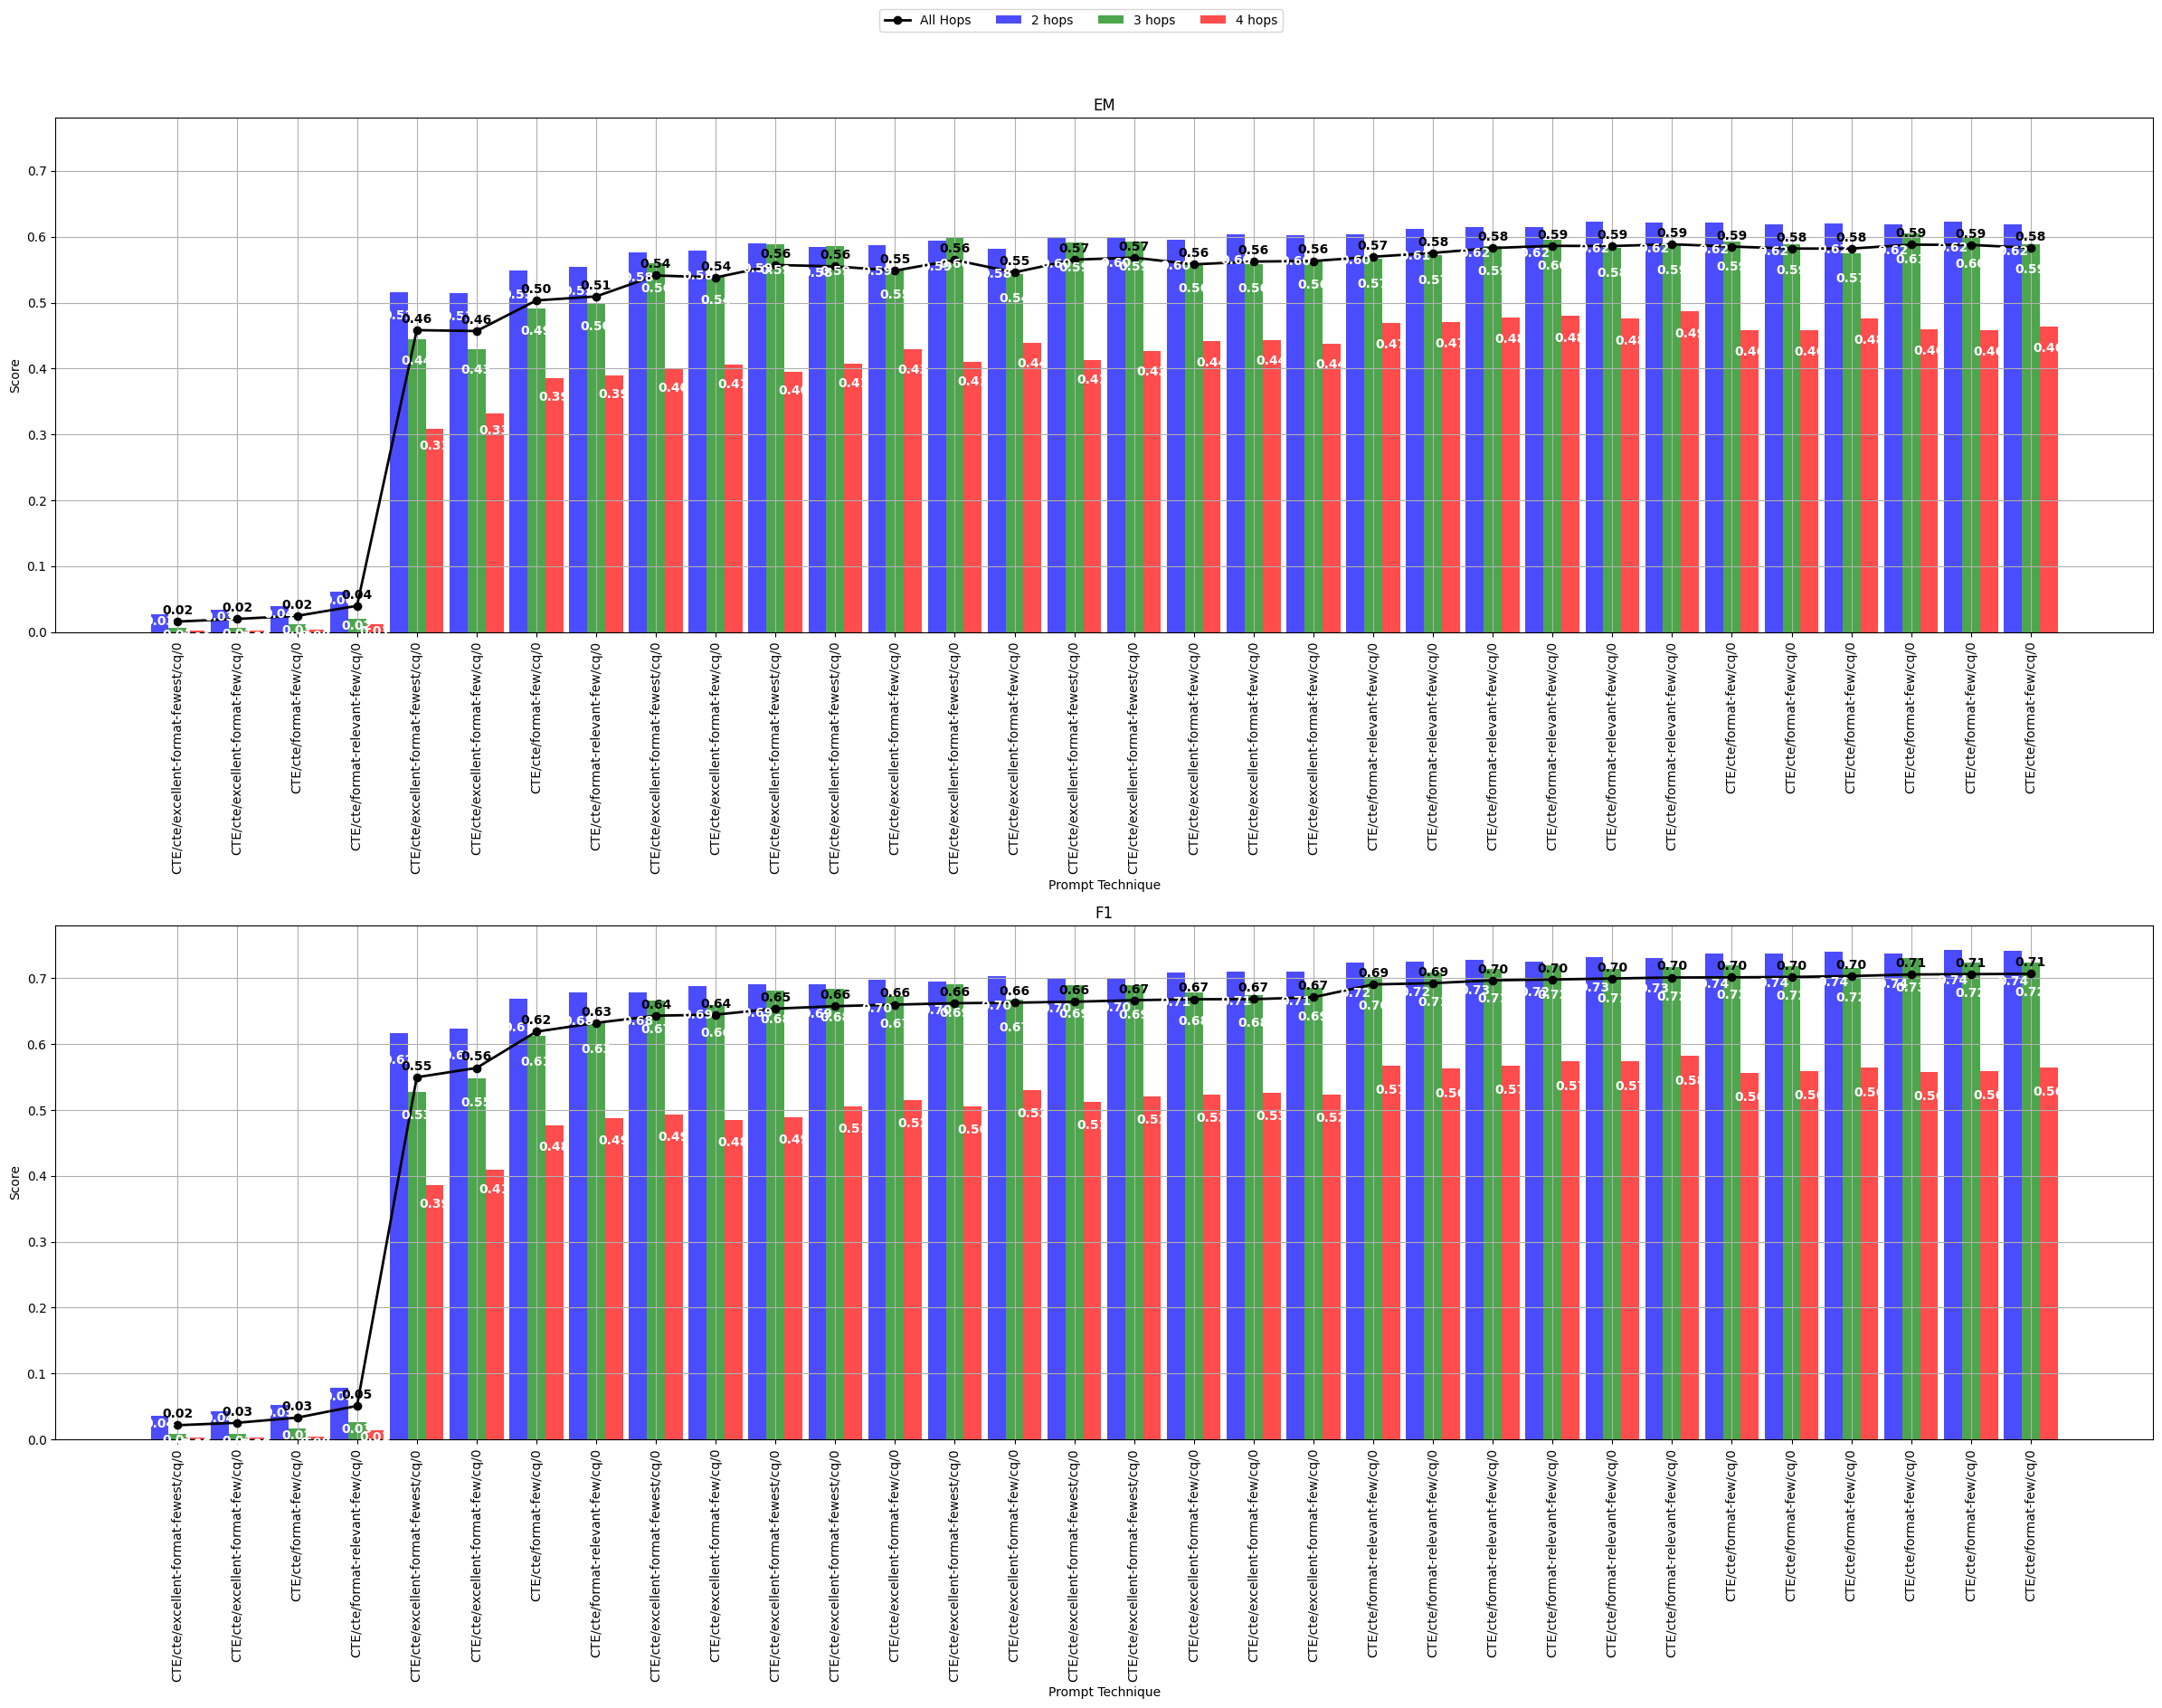

In [50]:
mask = df_target['params.qa.technique'] == 'CTE'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
8,COT,cot/format-minimal,cq,0,0.0,0.553855,0.667542,0.604899,0.719454,0.527632,0.652391,0.445267,0.535496
12,COT,cot/format-minimal,cq,0,0.7,0.549579,0.665909,0.603834,0.722626,0.521491,0.650191,0.434568,0.520071
9,COT,cot/format-minimal,cq,0,0.1,0.550545,0.664687,0.601171,0.717966,0.526316,0.652606,0.439506,0.522651
11,COT,cot/format-minimal,cq,0,0.5,0.546545,0.662148,0.604899,0.721064,0.522368,0.651842,0.411523,0.499359
10,COT,cot/format-minimal,cq,0,0.3,0.543787,0.660145,0.604100,0.723095,0.514035,0.642496,0.413169,0.498661
27,COT,cot/format-think,cq,0,0.5,0.538408,0.659261,0.598509,0.720166,0.505263,0.638708,0.414815,0.509550
26,COT,cot/format-think,cq,0,0.3,0.533857,0.656207,0.593184,0.715728,0.500439,0.637942,0.413169,0.506481
28,COT,cot/format-think,cq,0,0.7,0.537443,0.655986,0.599840,0.719087,0.500000,0.634702,0.414815,0.500860
24,COT,cot/format-think,cq,0,0.0,0.534133,0.655633,0.595048,0.716456,0.500000,0.633874,0.409877,0.508437
25,COT,cot/format-think,cq,0,0.1,0.532616,0.654867,0.595048,0.717617,0.496053,0.631162,0.408230,0.505368


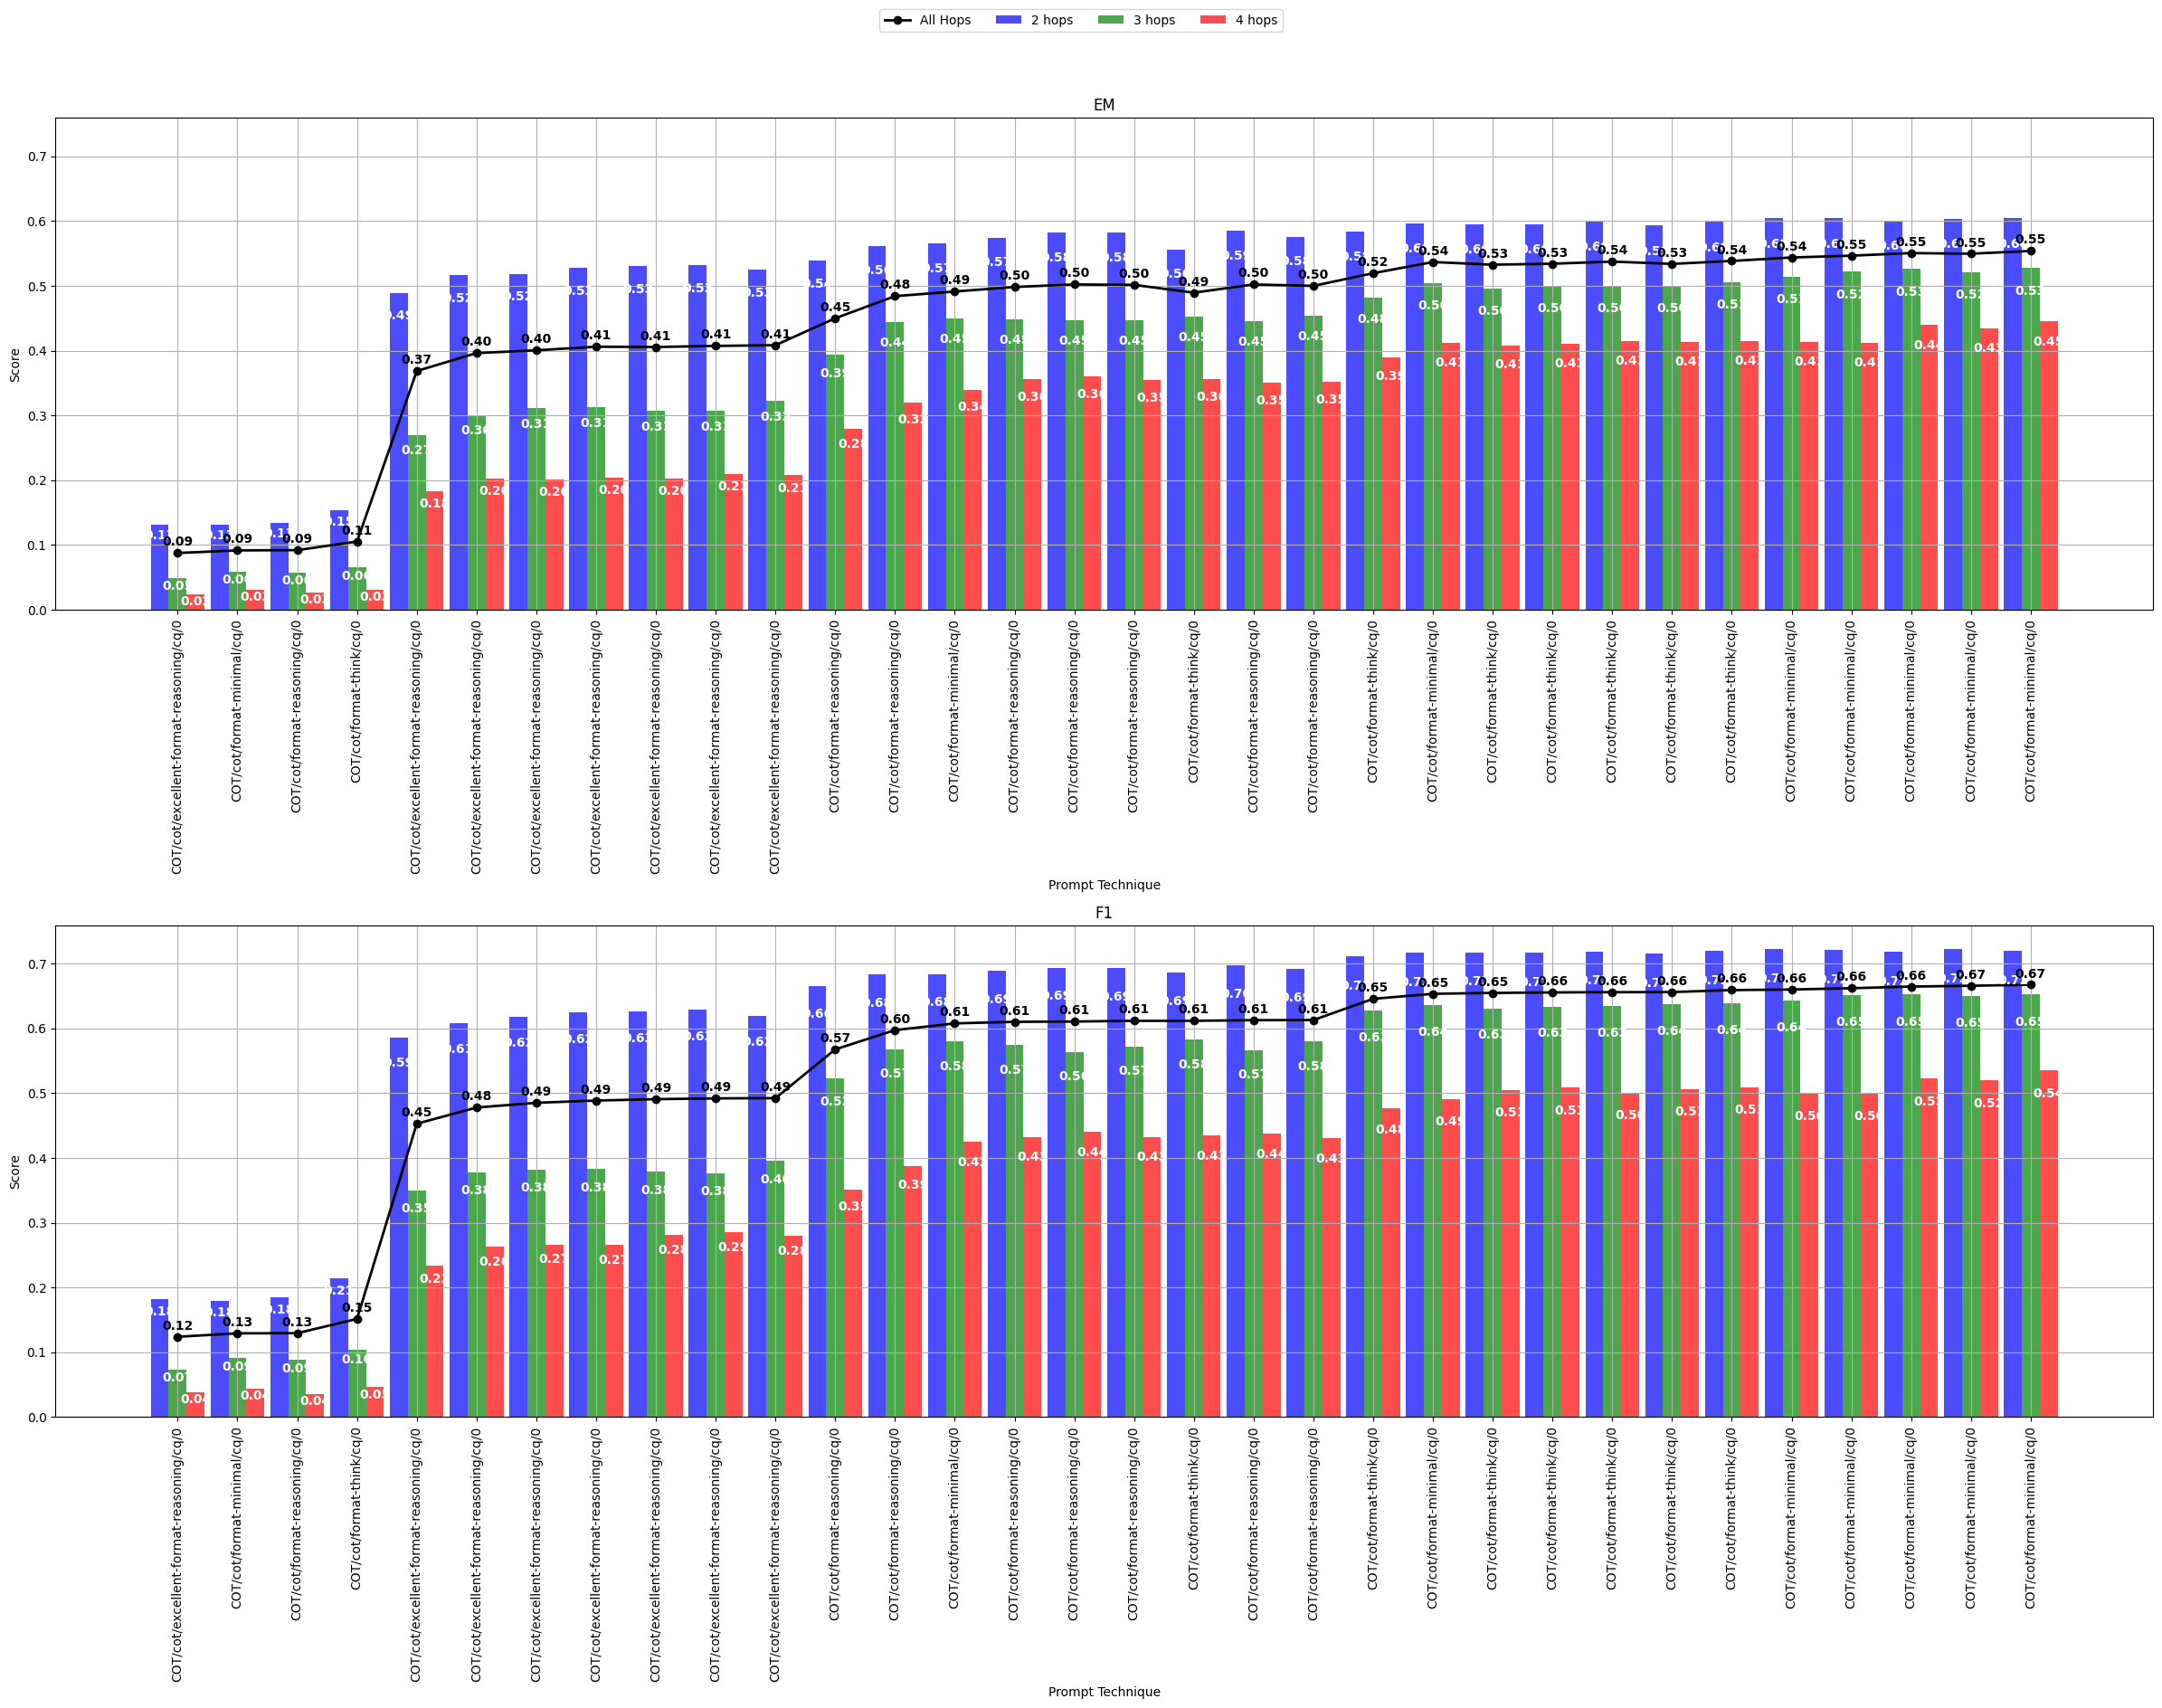

In [51]:
mask = df_target['params.qa.technique'] == 'COT'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)